In [1]:
import utils

import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.io import output_notebook
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

C:\ProgramData\Miniconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pal_df = utils.pal().reset_index()
isolf_df = utils.isolf().reset_index()
pal_df.head()

,Time Stamp,pal_min,pal_max,pal_mean
0,2005-02-01,0.0,7154.7,5580.662630
1,2005-02-02,0.0,7153.9,5535.835517
2,2005-02-03,0.0,7152.1,5514.954639
3,2005-02-04,0.0,6890.1,5717.773469
4,2005-02-05,4299.9,5990.4,5130.559122


In [3]:
# We can merge our two datasets and add some nuance to our dates
df = pal_df.merge(isolf_df, on='Time Stamp', sort=True)
df['weekday'] = df['Time Stamp'].dt.weekday
df['week'] = df['Time Stamp'].dt.week
df['month'] = df['Time Stamp'].dt.month
df['year'] = df['Time Stamp'].dt.year
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5513 entries, 0 to 5512
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Time Stamp  5513 non-null   datetime64[ns]
 1   pal_min     5513 non-null   float64       
 2   pal_max     5513 non-null   float64       
 3   pal_mean    5513 non-null   float64       
 4   isolf_min   5513 non-null   float64       
 5   isolf_max   5513 non-null   float64       
 6   isolf_mean  5513 non-null   float64       
 7   weekday     5513 non-null   int64         
 8   week        5513 non-null   int64         
 9   month       5513 non-null   int64         
 10  year        5513 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 516.8 KB


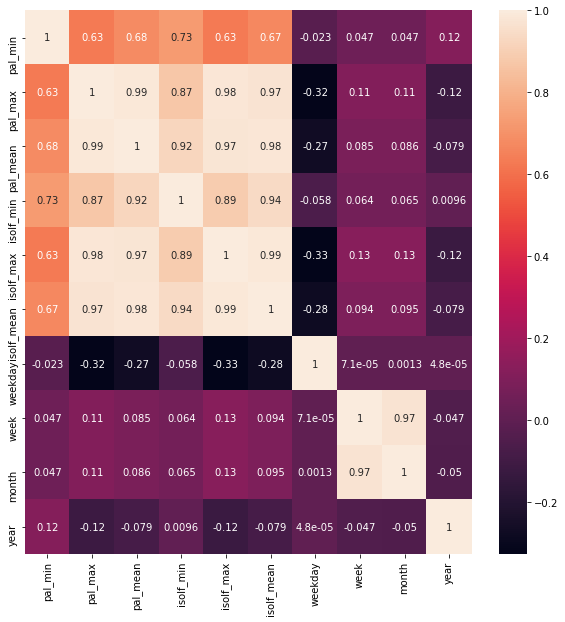

In [4]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=corr, ax=ax, annot=True)

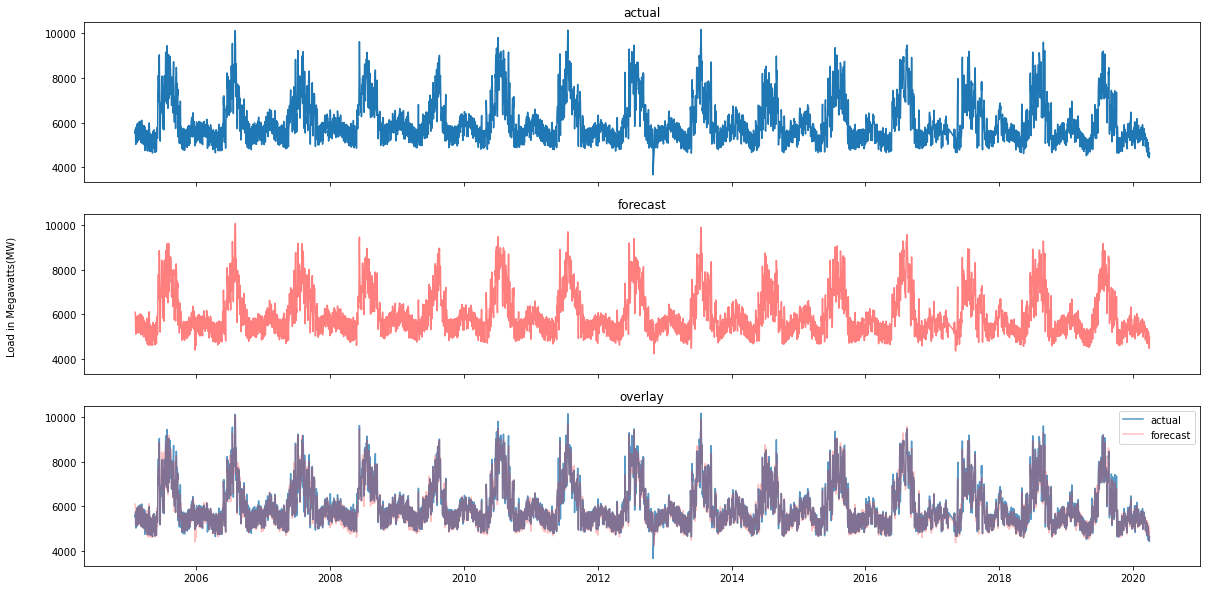

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(20,10), sharex=True, sharey=True)
axes[0].plot(df['Time Stamp'], df['pal_mean'])
axes[0].set_title('actual')
axes[1].plot(df['Time Stamp'], df['isolf_mean'], c='red', alpha=.5)
axes[1].set_title('forecast')
axes[2].plot(df['Time Stamp'], df['pal_mean'], label='actual', alpha=.75, ms=.5)
axes[2].plot(df['Time Stamp'], df['isolf_mean'], c='red', alpha=.25, label='forecast', ms=.5)
axes[2].set_title('overlay')
axes[2].legend()
fig.text(.075, .5, 'Load in Megawatts(MW)', ha='center', va='center', rotation='vertical')
plt.show()

#Lots of overlap! Means the ISO has done a good job forecasting so far.
# But outside of the seasonal cycles, we don't see a pronounced drop or increase over time. We can assume 
# probably assume relatively stability for now

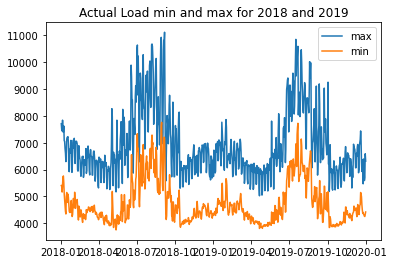

In [6]:
# Let's check out the regularity of our load data
mask = (df['Time Stamp'] > datetime.datetime(2018, 1, 1)) & (df['Time Stamp'] < datetime.datetime(2020, 1, 1))
plt.plot(df.loc[mask]['Time Stamp'], df.loc[mask]['pal_max'], ms=.5, label='max')
plt.plot(df.loc[mask]['Time Stamp'], df.loc[mask]['pal_min'], ms=.5, label='min')
plt.title('Actual Load min and max for 2018 and 2019')
plt.legend()
plt.show()

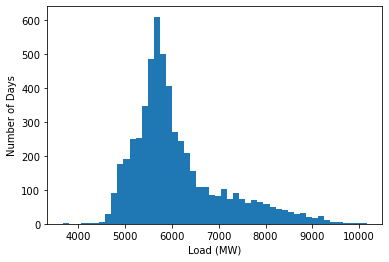

In [7]:
# Finally, let's check out the frequency of our load in histogram form
fig, ax = plt.subplots()
ax.set_xlabel('Load (MW)')
ax.set_ylabel('Number of Days')
ax.hist(df['pal_mean'], 50)
plt.show()

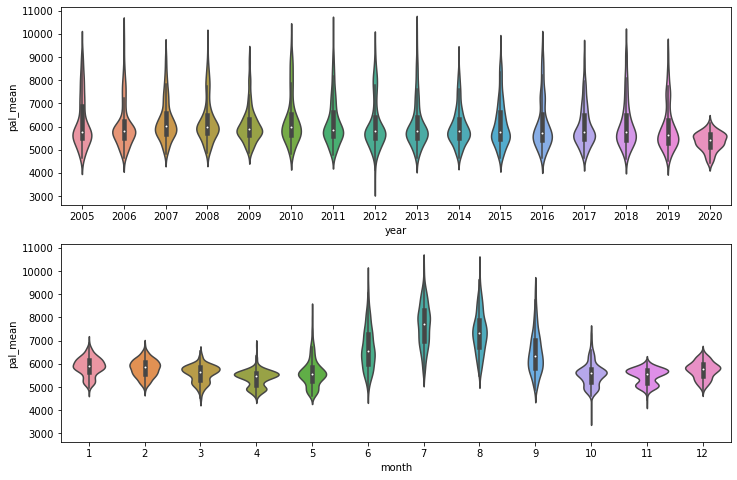

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharey=True)

sns.violinplot(df['year'], df['pal_mean'], ax=ax[0])
sns.violinplot(df['month'], df['pal_mean'], ax=ax[1])
plt.show()

# Here again we can see our distribution play out across multiple years settling between around our mean at 5.5k
# We can also see that most of the variation (our tails) can be accounted for in the summer months

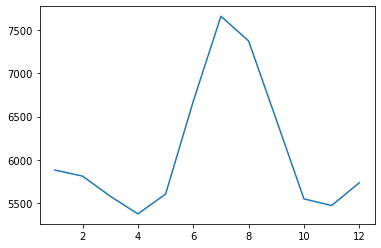

In [20]:
# Another interesting point is that in month 4 and 11 (april and november) we have local minimums for our line. 
# Most likely attritubted to a comfortable outside temp that doesn't require heating or cooling (~65F) ie. less heatng/cooling degree days

months = df.groupby('month').mean().reset_index()
plt.plot(months['month'], months['pal_mean'])
plt.show()

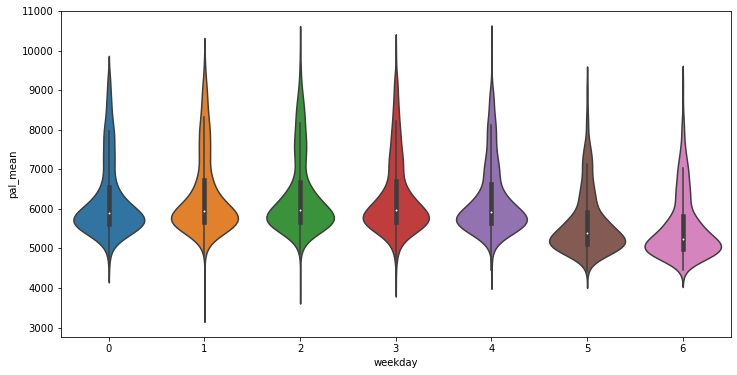

In [10]:
 # We also notice that weekday has some correlation to our load value. Let's check it out further

fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(df['weekday'], df['pal_mean'])
plt.show()

Wonderful! We see that the weekends (weekday 5 and 6) are shaped similar, but have a lower center.

We can also assume that we will see the same week/end flucuation within the seasonal variation discovered